# SegNet model implemented with keras

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import sys

from skimage.io import imread
from matplotlib import pyplot as plt

import os
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN, device=gpu0, floatX=float32, optimizer=fast_compile'

from keras import models
from keras.optimizers import SGD

Using Theano backend.
Using gpu device 0: GeForce GTX 560 Ti (CNMeM is disabled, cuDNN not available)


### Data set characteristics

In [2]:
path = 'Data/'
img_w = 256
img_h = 256
n_labels = 2

n_train = 6
n_test = 3

### Utility functions

In [3]:
def label_map(labels):
    label_map = np.zeros([img_h, img_w, n_labels])    
    for r in range(img_h):
        for c in range(img_w):
            label_map[r, c, labels[r][c]] = 1
    return label_map

In [4]:
def prep_data(mode):
    assert mode in {'test', 'train'}, \
        'mode should be either \'test\' or \'train\''
    data = []
    label = []
    df = pd.read_csv(path + mode + '.csv')
    n = n_train if mode == 'train' else n_test
    for i, item in df.iterrows():
        if i >= n:
            break
        img, gt = [imread(path + item[0])], np.clip(imread(path + item[1]), 0, 1)
        data.append(img)
        label.append(label_map(gt))
        sys.stdout.write('\r')
        sys.stdout.write(mode + ": [%-20s] %d%%" % ('=' * int(20. * (i + 1) / n - 1) + '>',
                                                    int(100. * (i + 1) / n)))
        sys.stdout.flush()
    sys.stdout.write('\r')
    sys.stdout.flush()
    data, label = np.array(data), np.array(label).reshape((n, img_h * img_w, n_labels))

    print mode + ': OK'
    print '\tshapes: {}, {}'.format(data.shape, label.shape)
    print '\ttypes:  {}, {}'.format(data.dtype, label.dtype)
    print '\tmemory: {}, {} MB'.format(data.nbytes / 1048576, label.nbytes / 1048576)

    return data, label

In [5]:
def plot_results(output):
    gt = []
    df = pd.read_csv(path + 'test.csv')
    for i, item in df.iterrows():
        gt.append(np.clip(imread(path + item[1]), 0, 1))

    plt.figure(figsize=(15, 2 * n_test))
    for i, item in df.iterrows():
        plt.subplot(n_test, 4, 4 * i + 1)
        plt.title('Ground Truth')
        plt.axis('off')
        gt = imread(path + item[1])
        plt.imshow(np.clip(gt, 0, 1))

        plt.subplot(n_test, 4, 4 * i + 2)
        plt.title('Prediction')
        plt.axis('off')
        labeled = np.argmax(output[i], axis=-1)
        plt.imshow(labeled)

        plt.subplot(n_test, 4, 4 * i + 3)
        plt.title('Heat map')
        plt.axis('off')
        plt.imshow(output[i][:, :, 1])

        plt.subplot(n_test, 4, 4 * i + 4)
        plt.title('Comparison')
        plt.axis('off')
        rgb = np.empty((img_h, img_w, 3))
        rgb[:, :, 0] = labeled
        rgb[:, :, 1] = imread(path + item[0])
        rgb[:, :, 2] = gt
        plt.imshow(rgb)

    plt.savefig('result.png')
    plt.show()

### Loading and compiling model built with *'build_model.py'*

In [6]:
with open('model_5l.json') as model_file:
    autoencoder = models.model_from_json(model_file.read())

optimizer = SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False)
autoencoder.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
print 'Compiled: OK'

Compiled: OK


### Train model or load existing weights

In [7]:
# train_data, train_label = prep_data('train')
# nb_epoch = 50
# batch_size = 18
# history = autoencoder.fit(train_data, train_label, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)
# autoencoder.save_weights('model_5l_weight_ep50.hdf5')

autoencoder.load_weights('model_5l_weight_ep50.hdf5')

### Model visualization

In [8]:
from keras.utils.visualize_util import plot
plot(autoencoder, to_file='model.png', show_shapes=True)

### Load testing data and evaluate score

In [9]:
test_data, test_label = prep_data('test')
score = autoencoder.evaluate(test_data, test_label, verbose=0)
print 'Test score:', score[0]
print 'Test accuracy:', score[1]

test: OK
	shapes: (3, 1, 256, 256), (3, 65536, 2)
	types:  uint8, float64
	memory: 0, 3 MB
Test score: 0.166390642524
Test accuracy: 0.970331847668


### Visualizing results

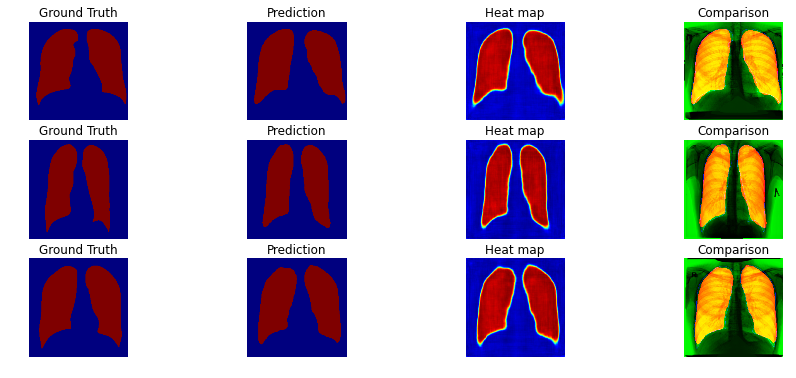

In [10]:
output = autoencoder.predict_proba(test_data, verbose=0)
output = output.reshape((output.shape[0], img_h, img_w, n_labels))

plot_results(output)